# Sigma Delta Design with CBADC (IMSE 2025)

To run this tutorial you need Python (>=3.10) installed.

It's good practice to install dependencies in a [local virtual environment using venv package](https://docs.python.org/3/library/venv.html).

To create the `imse2025` venv and install the [cbadc python package](https://github.com/hammal/cbadc/tree/feature/0.4.0) run the following code.

``` bash
python -m venv imse2025
source imse2025/bin/activate && \
python -m pip install --upgrade pip ipykernel jupyterlab && \
python -m ipykernel install --user --name=imse2025 --display-name "imse 2025"
```

For the SDM design this [Python port of the Schreier's MATLAB toolbox](http://www.python-deltasigma.io) is heavily used.

### Finding this tutorial

The tutorial can be found in the [https://github.com/hammal/IMSE2025](https://github.com/hammal/IMSE2025/blob/main/tutorial.ipynb) GitHub repo.

Below follows a QR code with the address

In [ ]:
%pip install --upgrade qrcode Pillow
import qrcode
qr = qrcode.make("https://github.com/hammal/IMSE2025/blob/main/tutorial.ipynb")
display(qr)

### Installing Python Packages

The [cbadc](https://github.com/hammal/cbadc/tree/feature/0.4.0) package and all dependencies can directly be installed using the following [pip](https://packaging.python.org/en/latest/guides/tool-recommendations/) command

```bash
python -m pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0
```

upon release this will be
``` bash
python -m pip install cbadc
```

In [1]:
%pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0

  Cloning https://github.com/hammal/cbadc.git (to revision feature/0.4.0) to /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-dby_snp1
  Running command git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-dby_snp1
  Running command git checkout -b feature/0.4.0 --track origin/feature/0.4.0
  Switched to a new branch 'feature/0.4.0'
  branch 'feature/0.4.0' set up to track 'origin/feature/0.4.0'.
  Resolved https://github.com/hammal/cbadc.git to commit d535f1aea6e7d47c80ba966fb1defcbb5b4dc52c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached deltasigma-0.2.6-py3-none-any.whl
  Created wheel for cbadc: filename=cbadc-0.4.0-py3-none-any.whl size=165661 sha256=4f226b2a6a26146f2d21a170dd88a9187e5d5c89db958926119e6f9a13f08d08
  Stored in directory: /private/var/folders/vy/xnxm11256

## Design example for a continuous-time lowpass DS ADC
Reproducing [dsexample2.m](https://se.mathworks.com/matlabcentral/fileexchange/19-delta-sigma-toolbox) from Shreier's delta sigma toolbox

We begin by instantiating all Python packages

In [2]:
import numpy as np
import cbadc as cb
import matplotlib.pyplot as plt

plotsize = (8, 4) #inches
plt.rcParams['figure.figsize'] = plotsize

In [3]:
order = 3
osr = 32
nlev = 2
f0 = 0.
Hinf = 1.5
tdac = [0, 1]
form = 'FB'
dt_form = 'CRFB'
Bw = 10e6
fs = Bw * osr * 2
print(f"fs = {fs/1e6} MHz")

fs = 640.0 MHz


In [4]:
ntf0 = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, f0) # 2: Optimized zero placement
# Extract zeros and poles from ntf0
zeros = ntf0.zeros
poles = ntf0.poles
for z, p in zip(ntf0.zeros, ntf0.poles):
    print("(%f, %fj)\t(%f, %fj)" % (np.real(z), np.imag(z), np.real(p), np.imag(p)))


(1.000000, 0.000000j)	(0.764515, -0.280052j)
(0.997110, 0.075973j)	(0.764515, 0.280052j)
(0.997110, -0.075973j)	(0.668460, 0.000000j)


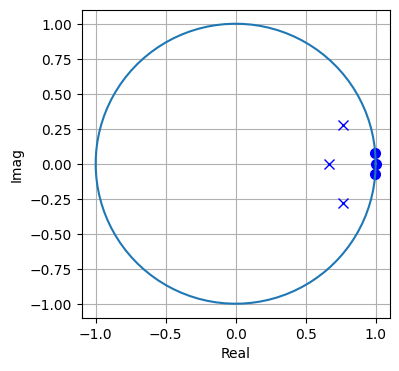

In [5]:
# Plot zeros and poles
cb.delsig.plotPZ(ntf0, showlist=False)
cb.delsig.changeFig(10, 1.5, 7)

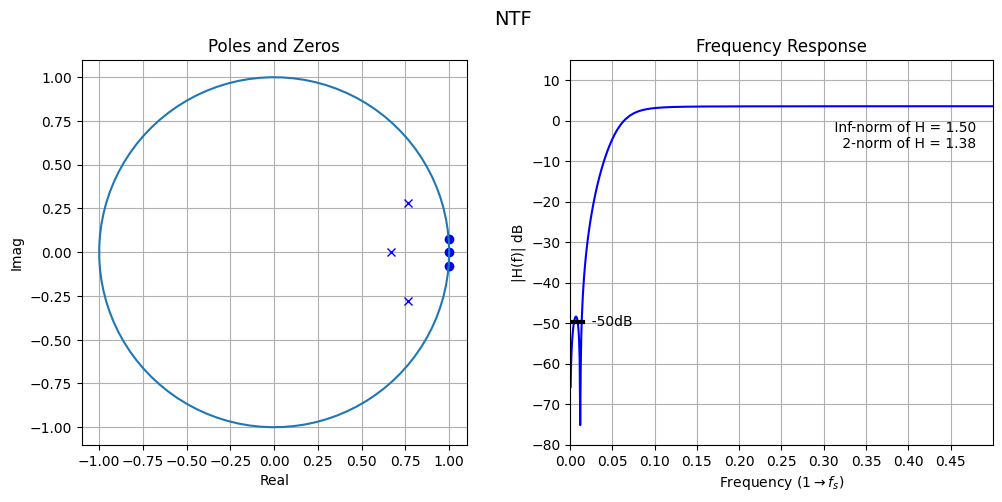

In [6]:
cb.delsig.DocumentNTF(ntf0, osr, f0, False)

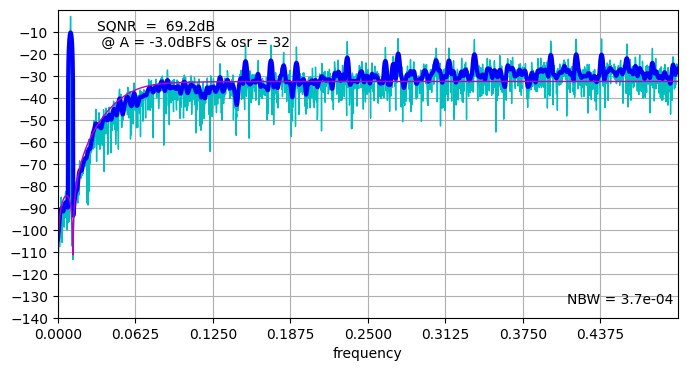

In [7]:
cb.delsig.PlotExampleSpectrum(ntf0, M, osr, f0)
# title('Example Spectrum');

In [8]:
# decide for a architecture
a, g, b, c = cb.delsig.realizeNTF(ntf0, form="CRFB")
ABCD = cb.delsig.stuffABCD(a, g, b, c)
dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
print(dt_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 1.          0.          0.        ]
 [ 1.          1.         -0.00578018]
 [ 1.          1.          0.99421982]],
B=
[[ 0.04438739 -0.04438739]
 [ 0.2398605  -0.2398605 ]
 [ 0.7967304  -0.7967304 ]],
C=
[[0. 0. 1.]],
D=
[[1. 0.]]),
   )  digital_control=DigitalControl(M=1, dt=1.0, dac_waveform=nrz),
  analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
  state_covariance=None,
  output_covariance=None,
  N=3,
  L=1,
  M=1,
  dt=1.0
)


In [9]:
ABCDc, tdac2 = cb.delsig.realizeNTF_ct(ntf0, form, tdac)
ct_analog_frontend = cb.AnalogFrontend.ctsdm(ABCDc, tdac2, quantization_levels=nlev)
# rescale to fs
ct_analog_frontend.dt = 1.0/fs
print(ct_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.40000000e+08  0.00000000e+00 -3.70110165e+06]
 [ 0.00000000e+00  6.40000000e+08  0.00000000e+00]],
B=
[[ 2.84216217e+07 -2.84216217e+07]
 [ 0.00000000e+00 -1.53584722e+08]
 [ 0.00000000e+00 -4.28829727e+08]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
   )  digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
  analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
  state_covariance=None,
  output_covariance=None,
  N=3,
  L=1,
  M=1,
  dt=1.5625e-09
)


/Users/hammal/Projects/IMSE2025/imse2025/lib/python3.13/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)
/Users/hammal/Projects/IMSE2025/imse2025/lib/python3.13/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


In [10]:
dt_ct_analog_frontend = ct_analog_frontend.discretize(dt=ct_analog_frontend.dt)
ABCD = dt_ct_analog_frontend.ABCD
print(dt_ct_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 1.          0.          0.        ]
 [ 0.99903645  0.99710991 -0.0057774 ]
 [ 0.49975909  0.99903645  0.99710991]],
B=
[[ 0.04440878 -0.04440878]
 [ 0.02219369 -0.2600021 ]
 [ 0.00739932 -0.7967304 ]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
   )  digital_control=DigitalControl(M=1, dt=1.0, dac_waveform=nrz),
  analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
  state_covariance=None,
  output_covariance=None,
  N=3,
  L=1,
  M=1,
  dt=1.0
)


In [11]:
snr_dt, amp_dt, _ = dt_analog_frontend.simulateSNR(osr)

INFO:root:Simulating discrete-time analog frontend


In [12]:
snr_ct, amp_ct, _ = ct_analog_frontend.simulateSNR(osr)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


In [13]:
snr_dt_ct, amp_dt_ct, _ = dt_ct_analog_frontend.simulateSNR(osr)

INFO:root:Simulating discrete-time analog frontend


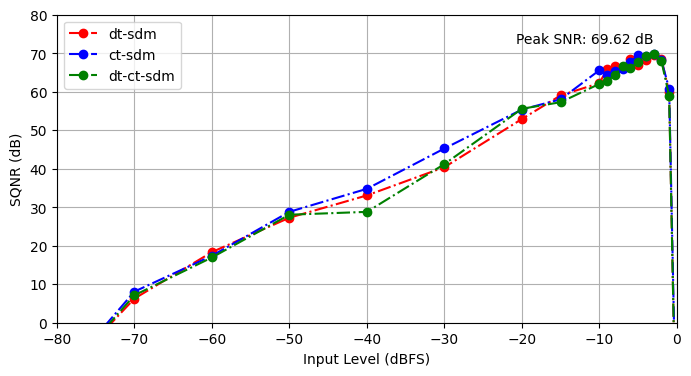

In [14]:
plt.plot(amp_dt, snr_dt, 'o-.r', label='dt-sdm')
plt.plot(amp_ct, snr_ct, 'o-.b', label='ct-sdm')
plt.plot(amp_dt_ct, snr_dt_ct, 'o-.g', label='dt-ct-sdm')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()

peak_amp_dt = np.argmax(snr_dt)
plt.text(amp_dt[peak_amp_dt], snr_dt[peak_amp_dt] + 3, f'Peak SNR: {snr_dt[peak_amp_dt]:.2f} dB', horizontalalignment='right')
plt.xlim((-80, 0))
plt.ylim((0, 80))
plt.legend()


## GmC Integrators

![The GmC block](gmc_from_simsides.png)

In [104]:
Ro = np.ones(order) * 1e5
Cp = np.ones(order) * 1e-15
Cint = np.ones(order) * 1e-12
slew_rate = 1e9 * np.ones(order)
max_output_swing = 1.0 * np.ones(order)
min_output_swing = -max_output_swing
v_noise_rms = 1e-3 * np.ones(order)
GmC = cb.GmC(ct_analog_frontend, Cint, Ro, Cp, v_n=v_noise_rms, slew_rate=slew_rate, v_out_max=max_output_swing, v_out_min=min_output_swing)
amp_gmc, snr_gmc, _ = GmC.simulateSNR(osr)
print(GmC)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


AnalogFrontend(
  analog_filter=StateSpace(
A=
[[-9.99000999e+06  0.00000000e+00  0.00000000e+00]
 [ 6.40000000e+08 -9.99000999e+06 -3.70110165e+06]
 [ 0.00000000e+00  6.40000000e+08 -9.99000999e+06]],
B=
[[ 2.84216217e+07 -2.84216217e+07]
 [ 0.00000000e+00 -1.53584722e+08]
 [ 0.00000000e+00 -4.28829727e+08]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
   )  digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
  analog_signal=Sinusoidal parameterized as:
amplitude = [[1.]],
frequency = [[5000000.]],
phase = [[0.]],
offset = [[0.]],
  state_covariance=[[1.e-06 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 1.e-06]],
  output_covariance=None,
  N=3,
  L=1,
  M=1,
  dt=1.5625e-09
)


In [105]:
print(f"The GmC:\n{GmC.gm}")

The GmC:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.84216217e-05
  -2.84216217e-05]
 [ 6.40000000e-04  0.00000000e+00 -3.70110165e-06  0.00000000e+00
  -1.53584722e-04]
 [ 0.00000000e+00  6.40000000e-04  0.00000000e+00  0.00000000e+00
  -4.28829727e-04]]


In [106]:
print(f"The DC_gain:\n{GmC.dc_gain}")

The DC_gain:
[[  0.           0.           0.           2.84216217  -2.84216217]
 [ 64.           0.          -0.37011017   0.         -15.35847219]
 [  0.          64.           0.           0.         -42.88297269]]


## Active RC Integrators

![The GmC block](active_rc_from_simsides.png)

In [112]:
Ro = 1e9 * np.ones(order)
Co = np.ones(order) * 1e-15
Cint = np.ones(order) * 1e-12
gm = 1e-5 * np.ones(order)
active_RC = cb.ActiveRC(ct_analog_frontend, Cint, gm, Ro, Co)
print(active_RC)
amp_active_rc, snr_active_rc, _ = active_RC.simulateSNR(osr)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


AnalogFrontend(
  analog_filter=StateSpace(
A=
[[-1.00000000e+10  0.00000000e+00  0.00000000e+00 -1.00000000e+06
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -1.06437011e+10  0.00000000e+00 -6.40000000e+08
  -1.00000000e+06  3.70110165e+06]
 [ 0.00000000e+00  0.00000000e+00 -1.06400000e+10 -0.00000000e+00
  -6.40000000e+08 -1.00000000e+06]
 [-1.00000000e+10 -0.00000000e+00 -0.00000000e+00 -1.00000000e+06
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -1.00000000e+10 -0.00000000e+00 -0.00000000e+00
  -1.00000000e+06 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.00000000e+10 -0.00000000e+00
  -0.00000000e+00 -1.00000000e+06]],
B=
[[ 2.84216217e+07 -2.84216217e+07]
 [ 0.00000000e+00 -1.53584722e+08]
 [ 0.00000000e+00 -4.28829727e+08]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]],
C=
[[ 0.  0.  0. -0. -0. -1.]],
D=
[[0. 0.]]),
   )  digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
  analo

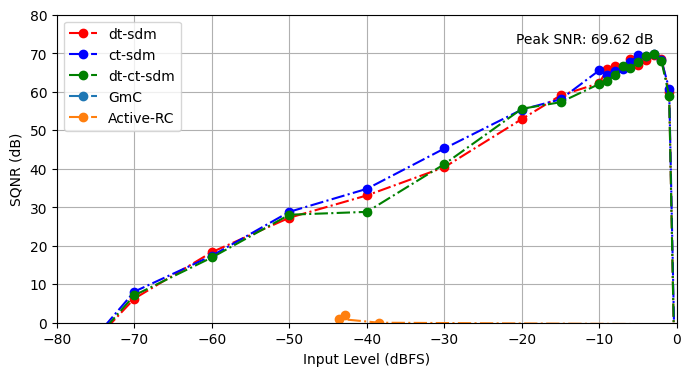

In [113]:
plt.plot(amp_dt, snr_dt, 'o-.r', label='dt-sdm')
plt.plot(amp_ct, snr_ct, 'o-.b', label='ct-sdm')
plt.plot(amp_dt_ct, snr_dt_ct, 'o-.g', label='dt-ct-sdm')
plt.plot(amp_gmc, snr_gmc, 'o-.', label='GmC')
plt.plot(amp_active_rc, snr_active_rc, 'o-.', label='Active-RC')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()

peak_amp_dt = np.argmax(snr_dt)
plt.text(amp_dt[peak_amp_dt], snr_dt[peak_amp_dt] + 3, f'Peak SNR: {snr_dt[peak_amp_dt]:.2f} dB', horizontalalignment='right')
plt.xlim((-80, 0))
plt.ylim((0, 80))
plt.legend()


In [114]:
size = 1 << 14

amplitude = np.array([[1.0]], dtype=float)
freq = np.array([[GmC.fs / 128]], dtype=float)
sinusoidal = cb.Sinusoidal(amplitude, freq)
print(sinusoidal)
GmC.analog_signal = sinusoidal
ct_analog_frontend.analog_signal = sinusoidal
active_RC.analog_signal = sinusoidal
# ct_analog_frontend.A += - 1e-7 * np.eye(order)

ct_idal_sim = ct_analog_frontend.simulate(size)
gmc_sim = GmC.simulate(size)
active_RC_sim = active_RC.simulate(size)

wiener_filter_ideal = ct_analog_frontend.wiener_filter(OSR=osr)
u_hat_ideal = wiener_filter_ideal.evaluate(ct_idal_sim["s"])[:, 0, :]

wf_gmc = GmC.wiener_filter(OSR=osr)
u_hat_gmc = wf_gmc.evaluate(gmc_sim["s"])[:, 0, :]

wf_active_rc = active_RC.wiener_filter(OSR=osr)
u_hat_active_rc = wf_active_rc.evaluate(active_RC_sim["s"])[:, 0, :]

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Sinusoidal parameterized as:
amplitude = [[1.]],
frequency = [[5000000.]],
phase = [[0.]],
offset = [[0.]]


INFO:root:Simulating continuous-time analog frontend for sinusoidal input
INFO:root:Simulating continuous-time analog frontend for sinusoidal input


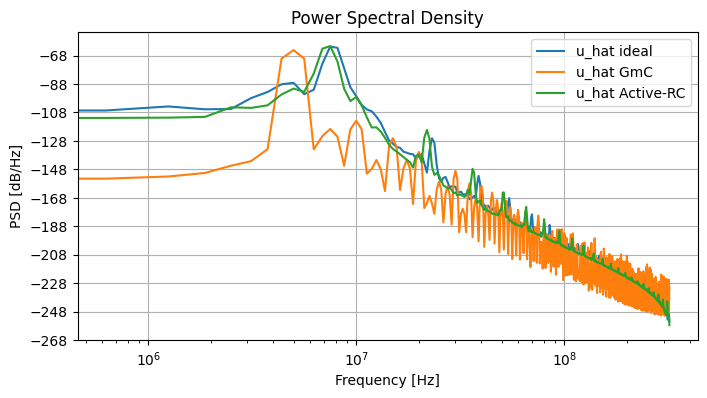

In [115]:
plt.figure()
plt.psd(u_hat_ideal.flatten(), NFFT=1024, Fs=1 / ct_analog_frontend.dt, label="u_hat ideal")
plt.psd(u_hat_gmc.flatten(), NFFT=1024, Fs=1 / GmC.dt, label="u_hat GmC")
plt.psd(u_hat_active_rc.flatten(), NFFT=1024, Fs=1 / active_RC.dt, label="u_hat Active-RC")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [dB/Hz]")
plt.title("Power Spectral Density")
plt.xscale("log")

Text(0, 0.5, 'Input')

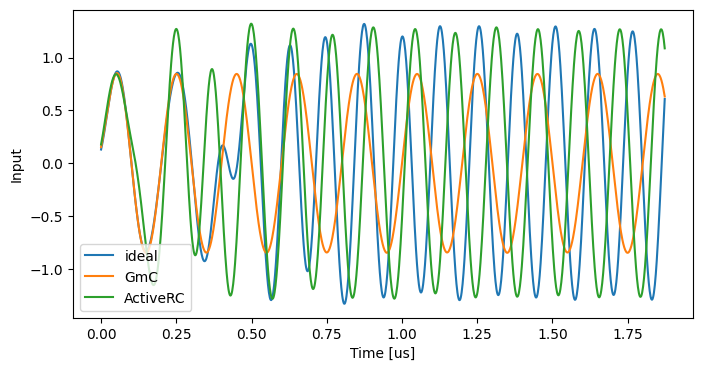

In [116]:
plt.figure()
length = 1200
# plt.plot(af_sim["t"][:length], u_hat[:length], label="ideal")
plt.plot(1e6 * ct_idal_sim["t"][:length], u_hat_ideal[:length], label="ideal")
plt.plot(1e6 * gmc_sim["t"][:length], u_hat_gmc[:length], label="GmC")
plt.plot(1e6 * active_RC_sim["t"][:length], u_hat_active_rc[:length], label="ActiveRC")
plt.legend()
plt.xlabel("Time [us]")
plt.ylabel("Input")

In [ ]:
print(ct_analog_frontend)

In [ ]:
print(GmC)

In [ ]:
print(active_RC)

In [ ]:
active_RC.simulateNGSpice(...)

## Outlook

Many features pending
- More advanced simulation reporting,
  - max currents,
  - max voltages,
  - ...
- FIR DAC support (implemented but has a bug)
- Refined GmC, activeRC parametrization and documentation
- MASH design flow
- Pipeline design flow
- ...

Also Validation against spice models